# IMPORTI

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# CITANJE DF-OVA

In [77]:
# UČITAVANJE REZULTATA
# Prilagodi imena CSV-ova!

df1 = pd.read_csv("neoptimizirano_2707/smoke_test/1_prompt_test_results.csv")
df2 = pd.read_csv("neoptimizirano_2707/smoke_test/2_chat_test_results.csv")
df3 = pd.read_csv("neoptimizirano_2707/smoke_test/3_summarize_test_results.csv")
df4 = pd.read_csv("neoptimizirano_2707/smoke_test/4_batch_test_results.csv")

smoke_df_losi = pd.concat([df1, df2, df3, df4], ignore_index=True)

df1 = pd.read_csv("optimizirano_2707/smoke_test/1_prompt_test_results.csv")
df2 = pd.read_csv("optimizirano_2707/smoke_test/2_chat_test_results.csv")
df3 = pd.read_csv("optimizirano_2707/smoke_test/3_summarize_test_results.csv")
df4 = pd.read_csv("optimizirano_2707/smoke_test/4_batch_test_results.csv")

smoke_df_ok = pd.concat([df1, df2, df3, df4], ignore_index=True)

dfa = pd.read_csv("neoptimizirano_2707/locust/1_prompt_test_results.csv")
dfb = pd.read_csv("neoptimizirano_2707/locust/2_chat_test_results.csv")
dfc = pd.read_csv("neoptimizirano_2707/locust/3_summarize_test_results.csv")
dfd = pd.read_csv("neoptimizirano_2707/locust/4_batch_test_results.csv")

locust_df_losi = pd.concat([dfa, dfb, dfc, dfd], ignore_index=True)


dfa = pd.read_csv("optimizirano_2707/locust/1_prompt_test_results.csv")
dfb = pd.read_csv("optimizirano_2707/locust/2_chat_test_results.csv")
dfc = pd.read_csv("optimizirano_2707/locust/3_summarize_test_results.csv")
dfd = pd.read_csv("optimizirano_2707/locust/4_batch_test_results.csv")

locust_df_ok = pd.concat([dfa, dfb, dfc, dfd], ignore_index=True)   # Pretpostavi ime datoteke

smoke_df_losi['test_type'] = 'smoke_neoptimizirano'
smoke_df_ok['test_type'] = 'smoke_optimizirano'
locust_df_losi['test_type'] = 'stress_neoptimizirano'
locust_df_ok['test_type'] = 'stress_optimizirano'

triton_df_losi = pd.read_csv('neoptimizirano_triton.csv')
triton_df_ok = pd.read_csv('optimizirano_triton.csv')

triton_df_losi ['test_type'] = 'neoptimizirano'
triton_df_ok['test_type'] = 'optimizirano'

# remove gemma3 from the df
locust_df_losi = locust_df_losi[~locust_df_losi['model'].str.contains('gemma3')]
locust_df_ok = locust_df_ok[~locust_df_ok['model'].str.contains('gemma3')]

# join user_df and locust_df
df = pd.concat([smoke_df_losi, smoke_df_ok, locust_df_losi, locust_df_ok], ignore_index=True)

df_triton = pd.concat([triton_df_losi, triton_df_ok], ignore_index=True)


df['tokens_per_sec'] = pd.to_numeric(df['tokens_per_sec'], errors='coerce')
df.dtypes
#df.groupby(['model', 'test_type', 'test_name']).size()

timestamp          object
test_name          object
prompt_index      float64
model              object
prompt             object
ttft              float64
tpot              float64
tokens_per_sec    float64
latency           float64
prompt_tokens     float64
output_tokens     float64
output_text        object
status_code       float64
test_type          object
dtype: object

# MICANJE OUTLIERA

In [68]:
# Makni ako je potrebno, da ne strše vrijednosti...

def remove_outliers_iqr_for_group(df, filter_column, filter_value, target_column):
    df_target = df[df[filter_column] == filter_value]
    df_other = df[df[filter_column] != filter_value]

    Q1 = df_target[target_column].quantile(0.25)
    Q3 = df_target[target_column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filtriraj inliers
    df_target_clean = df_target[(df_target[target_column] >= lower_bound) & (df_target[target_column] <= upper_bound)]

    # Ako su svi redovi izbačeni, zadrži jedan (npr. onaj s medijanom)
    if df_target_clean.empty:
        median_value = df_target[target_column].median()
        closest_row = df_target.iloc[(df_target[target_column] - median_value).abs().argsort()[:1]]
        df_target_clean = closest_row

    return pd.concat([df_target_clean, df_other], ignore_index=True)


df = remove_outliers_iqr_for_group(df, 'test_name', 'chat', 'latency')
df = remove_outliers_iqr_for_group(df, 'test_name', 'chat', 'ttft')
df = remove_outliers_iqr_for_group(df, 'test_name', 'summarizer', 'tpot')
df = remove_outliers_iqr_for_group(df, 'test_name', 'summarizer', 'tokens_per_sec')



TypeError: '<' not supported between instances of 'str' and 'float'

# OBRADA STRESS I SMOKE TESTOVA

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prikaz osnovne tablice željenih metrika
important_cols = ['model', 'test_name', 'test_type', 'ttft', 'tpot', 'tokens_per_sec', 'latency']

# Create the summary DataFrame globally
summary = df.groupby(['model', 'test_name', 'test_type']).agg({
    'ttft': 'mean',
    'tpot': 'mean',
    'tokens_per_sec': 'mean',
    'latency': 'mean'
}).reset_index()

def summary_statistics(df, model, test_type):
    if model is not None:
        df = df[df['model'] == model]
    if test_type is not None:
        df = df[df['test_type'] == test_type]

    summary = df.groupby(['model', 'test_name', 'test_type']).agg({
        'ttft': 'mean',
        'tpot': 'mean',
        'tokens_per_sec': 'mean',
        'latency': 'mean'
    }).reset_index()
    display(summary)

models = df.model.unique()
test_types = df.test_type.unique()

for model in models:
    for ttype in test_types:
        summary_statistics(df, model, ttype)

stress_summary = summary[summary['test_type'] == 'single']



,model,test_name,test_type,ttft,tpot,tokens_per_sec,latency
0,gemma3,batch,smoke_neoptimizirano,0.024317,0.029699,0.000000,0.029699
1,gemma3,chat,smoke_neoptimizirano,13.060514,0.029978,119.263544,13.069311
2,gemma3,single,smoke_neoptimizirano,2.796942,0.021250,88.336651,2.805369
3,gemma3,summarizer,smoke_neoptimizirano,0.631874,0.641031,0.000000,0.641031


,model,test_name,test_type,ttft,tpot,tokens_per_sec,latency
0,gemma3,batch,smoke_optimizirano,32.979822,0.275917,31.947949,32.986820
1,gemma3,chat,smoke_optimizirano,12.821413,0.030116,97.093191,12.829133
2,gemma3,single,smoke_optimizirano,2.783373,0.021125,73.994999,2.791886
3,gemma3,summarizer,smoke_optimizirano,36.920639,0.003018,331.385987,36.929745


,model,test_name,test_type,ttft,tpot,tokens_per_sec,latency


,model,test_name,test_type,ttft,tpot,tokens_per_sec,latency


,model,test_name,test_type,ttft,tpot,tokens_per_sec,latency
0,mistral,batch,smoke_neoptimizirano,0.024164,0.028802,0.000000,0.028802
1,mistral,chat,smoke_neoptimizirano,2.761954,0.010340,136.269727,2.771834
2,mistral,single,smoke_neoptimizirano,2.520385,0.018379,55.600326,2.528891
3,mistral,summarizer,smoke_neoptimizirano,3.360186,0.000238,4205.050372,3.369044


,model,test_name,test_type,ttft,tpot,tokens_per_sec,latency
0,mistral,batch,smoke_optimizirano,3.198348,0.024785,41.907760,3.206256
1,mistral,chat,smoke_optimizirano,2.623166,0.009819,140.746830,2.631038
2,mistral,single,smoke_optimizirano,2.517708,0.018405,55.185370,2.526259
3,mistral,summarizer,smoke_optimizirano,3.413041,0.000241,4143.679856,3.418942


,model,test_name,test_type,ttft,tpot,tokens_per_sec,latency
0,mistral,batch,stress_neoptimizirano,0.029330,0.036521,0.000000,0.036521
1,mistral,chat,stress_neoptimizirano,372.947117,0.562653,3.262973,372.972992
2,mistral,single,stress_neoptimizirano,132.441519,1.193406,0.970725,132.450782
3,mistral,summarizer,stress_neoptimizirano,135.895363,0.009698,103.567846,135.903914


,model,test_name,test_type,ttft,tpot,tokens_per_sec,latency
0,mistral,batch,stress_optimizirano,30.208429,0.249207,4.698460,30.219084
1,mistral,chat,stress_optimizirano,199.242897,0.229825,8.118969,199.298626
2,mistral,single,stress_optimizirano,66.982331,0.517803,2.548666,67.000131
3,mistral,summarizer,stress_optimizirano,76.914237,0.005490,213.115047,76.936117


,model,test_name,test_type,ttft,tpot,tokens_per_sec,latency
0,meta-llama,batch,smoke_neoptimizirano,0.025606,0.030278,0.000000,0.030278
1,meta-llama,chat,smoke_neoptimizirano,2.737792,0.010286,135.702502,2.745932
2,meta-llama,single,smoke_neoptimizirano,2.721200,0.018817,53.595910,2.729685
3,meta-llama,summarizer,smoke_neoptimizirano,3.296707,0.000277,3605.633153,3.303442


,model,test_name,test_type,ttft,tpot,tokens_per_sec,latency
0,meta-llama,batch,smoke_optimizirano,3.373580,0.023415,42.931308,3.380215
1,meta-llama,chat,smoke_optimizirano,2.790512,0.010426,133.696066,2.797598
2,meta-llama,single,smoke_optimizirano,2.771576,0.019419,51.841055,2.780253
3,meta-llama,summarizer,smoke_optimizirano,3.280802,0.000276,3625.445935,3.285389


,model,test_name,test_type,ttft,tpot,tokens_per_sec,latency
0,meta-llama,batch,stress_neoptimizirano,0.033110,0.040642,0.000000,0.040642
1,meta-llama,chat,stress_neoptimizirano,389.026299,0.459715,3.181440,389.053141
2,meta-llama,single,stress_neoptimizirano,132.314467,0.915524,1.114936,132.324226
3,meta-llama,summarizer,stress_neoptimizirano,134.652148,0.011046,90.562146,134.661863


,model,test_name,test_type,ttft,tpot,tokens_per_sec,latency
0,meta-llama,batch,stress_optimizirano,24.084497,0.172753,6.186261,24.094519
1,meta-llama,chat,stress_optimizirano,172.463692,0.187088,10.147555,172.516703
2,meta-llama,single,stress_optimizirano,66.969528,0.466080,2.963896,66.985124
3,meta-llama,summarizer,stress_optimizirano,59.172330,0.004855,286.295365,59.188588


,model,test_name,test_type,ttft,tpot,tokens_per_sec,latency


,model,test_name,test_type,ttft,tpot,tokens_per_sec,latency


,model,test_name,test_type,ttft,tpot,tokens_per_sec,latency


,model,test_name,test_type,ttft,tpot,tokens_per_sec,latency
0,817.5294935134584,17.125948,stress_optimizirano,13885.0,14013.0,NaN,NaN


,model,test_name,test_type,ttft,tpot,tokens_per_sec,latency


,model,test_name,test_type,ttft,tpot,tokens_per_sec,latency


,model,test_name,test_type,ttft,tpot,tokens_per_sec,latency


,model,test_name,test_type,ttft,tpot,tokens_per_sec,latency
0,1068.599799252848,11.398592,stress_optimizirano,12063.0,12191.0,NaN,200.0


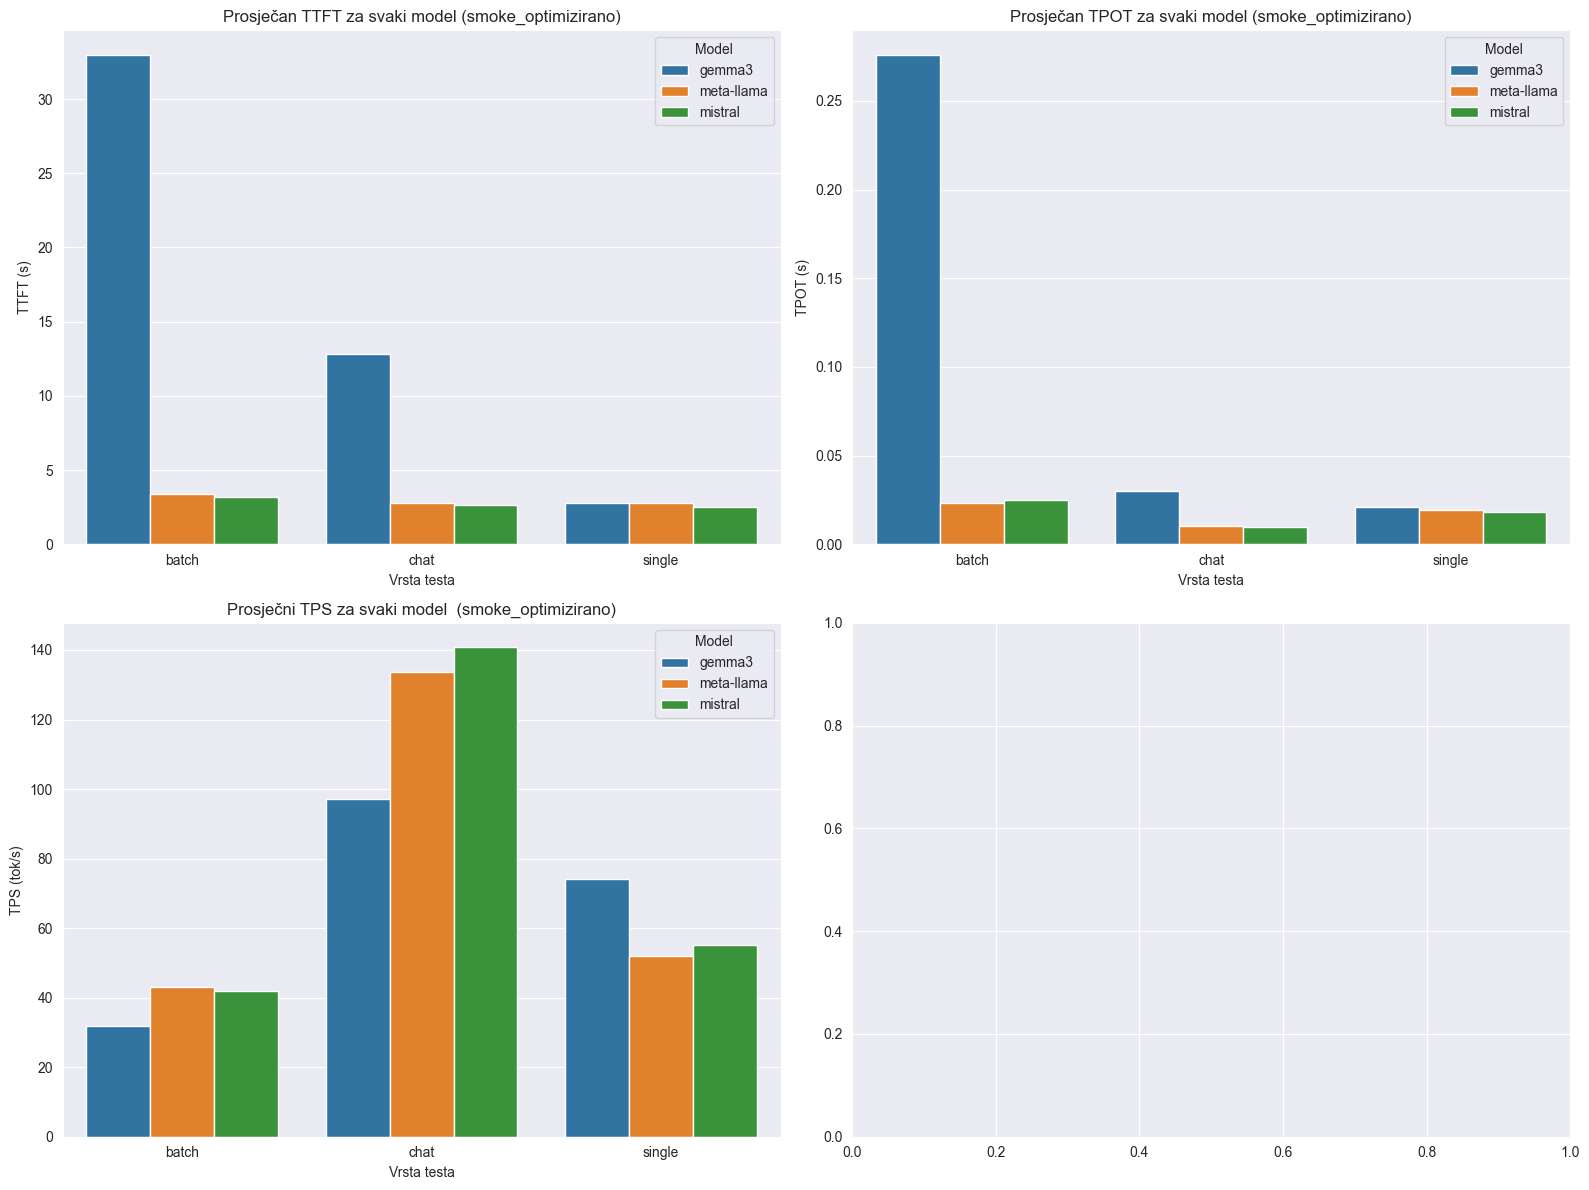

In [79]:
# Filtriraj po jednom testu
single_type = 'smoke_optimizirano'
filtered = summary[summary['test_type'] == single_type]
# makni sumarizer ako treba
filtered = filtered[~filtered['test_name'].str.contains('summarizer')]


fig, axes = plt.subplots(2, 2, figsize=(16, 12))

sns.barplot(data=filtered, x='test_name', y='ttft', hue='model', ax=axes[0, 0])
axes[0, 0].set_title(f'Prosječan TTFT za svaki model ({single_type})')

axes[0, 0].set_ylabel('TTFT (s)')
axes[0, 0].set_xlabel('Vrsta testa')
axes[0, 0].legend(title='Model')

sns.barplot(data=filtered, x='test_name', y='tpot', hue='model', ax=axes[0, 1])
axes[0, 1].set_title(f'Prosječan TPOT za svaki model ({single_type})')
axes[0, 1].set_ylabel('TPOT (s)')
axes[0, 1].set_xlabel('Vrsta testa')
axes[0, 1].legend(title='Model')

sns.barplot(data=filtered, x='test_name', y='tokens_per_sec', hue='model', ax=axes[1, 0])
axes[1, 0].set_title(f'Prosječni TPS za svaki model  ({single_type})')
axes[1, 0].set_ylabel('TPS (tok/s)')
axes[1, 0].set_xlabel('Vrsta testa')
axes[1, 0].legend(title='Model')

# ovo ne treba jer je ista kao i TTFT
# sns.barplot(data=filtered, x='test_name', y='latency', hue='model', ax=axes[1, 1])
# axes[1, 1].set_title(f'Prosječna latencija za svaki model ({single_type})')
# axes[1, 1].set_ylabel('Latency (s)')
# axes[1, 1].set_xlabel('Vrsta testa')
# axes[1, 1].legend(title='Model')

plt.tight_layout()
plt.show()

,model,test_name,ttft_ratio,tpot_ratio,tokens_per_sec_ratio,latency_ratio
0,1068.599799252848,11.398592,NaN,NaN,NaN,NaN
1,817.5294935134584,17.125948,NaN,NaN,NaN,NaN
2,meta-llama,batch,727.41,4.25,inf,592.84
3,meta-llama,chat,0.44,0.41,3.19,0.44
4,meta-llama,single,0.51,0.51,2.66,0.51
5,meta-llama,summarizer,0.44,0.44,3.16,0.44
6,mistral,batch,1029.94,6.82,inf,827.43
7,mistral,chat,0.53,0.41,2.49,0.53
8,mistral,single,0.51,0.43,2.63,0.51
9,mistral,summarizer,0.57,0.57,2.06,0.57


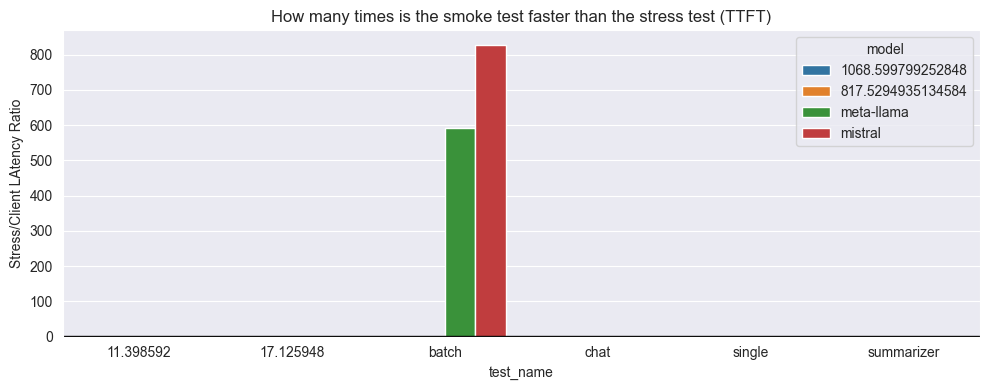

In [88]:
import numpy as np

# Remove 'gemma3' and aggregate
summary = df[~df['model'].str.contains('gemma3')].groupby(['model', 'test_name', 'test_type']).agg({
    'ttft': 'mean',
    'tpot': 'mean',
    'tokens_per_sec': 'mean',
    'latency': 'mean'
}).reset_index()

# Pivot with all expected test_type columns
pivot = summary.pivot(index=['model', 'test_name'], columns='test_type', values=['ttft', 'tpot', 'tokens_per_sec', 'latency'])
for metric in ['ttft', 'tpot', 'tokens_per_sec', 'latency']:
    for ttype in ['stress_optimizirano', 'stress_neoptimizirano']:
        if ttype not in pivot[metric].columns:
            pivot[metric][ttype] = np.nan
pivot.columns = [f'{metric}_{ttype}' for metric, ttype in pivot.columns]
pivot = pivot.reset_index()

metrics = ['ttft', 'tpot', 'tokens_per_sec', 'latency']
results = pivot[['model', 'test_name']].copy()

for metric in metrics:
    stress_neopt = pivot[f'{metric}_stress_optimizirano'].replace(0, 1e-6)
    stress_opt = pivot[f'{metric}_stress_neoptimizirano']
    ratio = stress_neopt / stress_opt
    results[f'{metric}_ratio'] = ratio.round(2)

from IPython.display import display
display(results)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
sns.barplot(data=results, x='test_name', y='latency_ratio', hue='model')
plt.ylabel('Stress/Client LAtency Ratio')
plt.title('How many times is the smoke test faster than the stress test (TTFT)')
plt.axhline(1, color='black', linewidth=1)
plt.tight_layout()
plt.show()


/var/folders/zz/g7jzxp0d6hg5w1dx9k26vpw00000gn/T/ipykernel_21699/1437942387.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Tip testa')


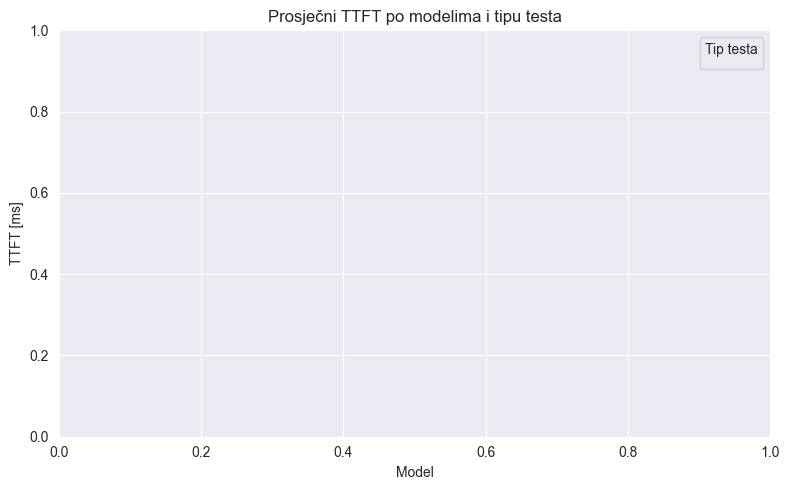

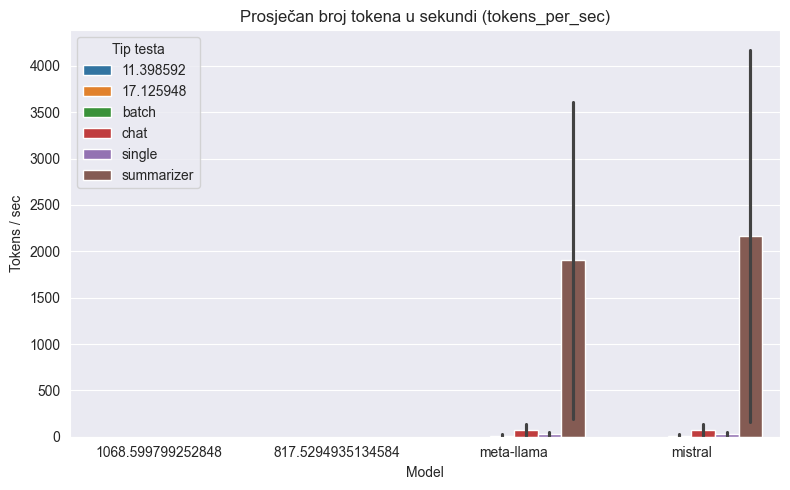

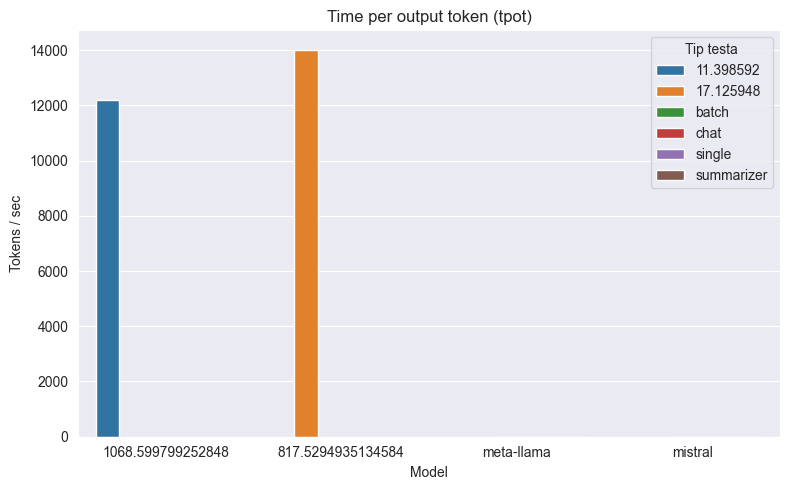

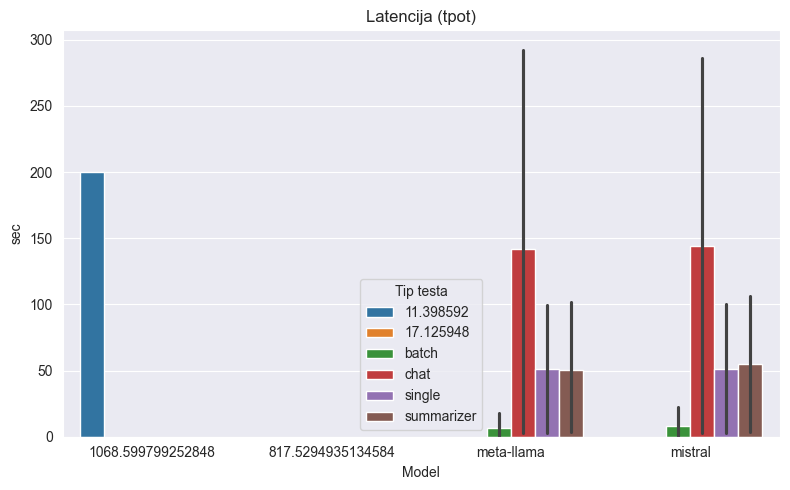

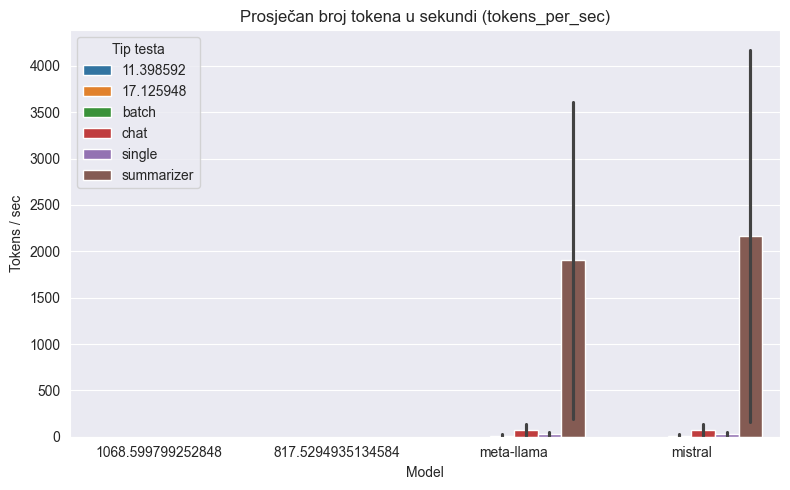

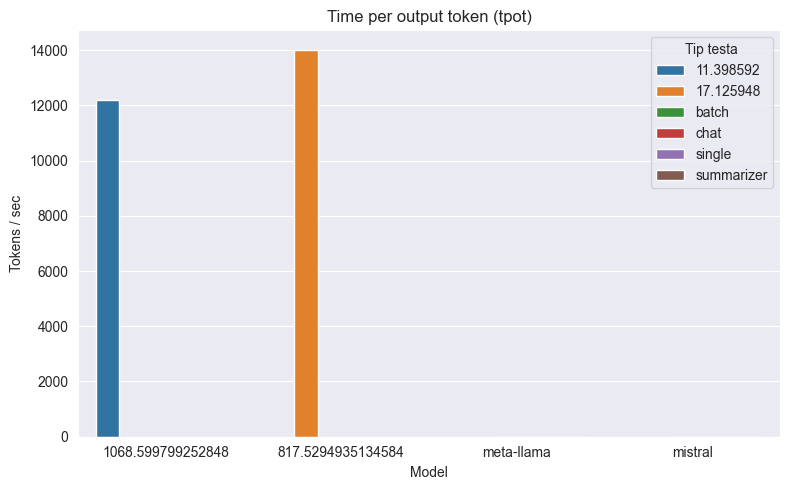

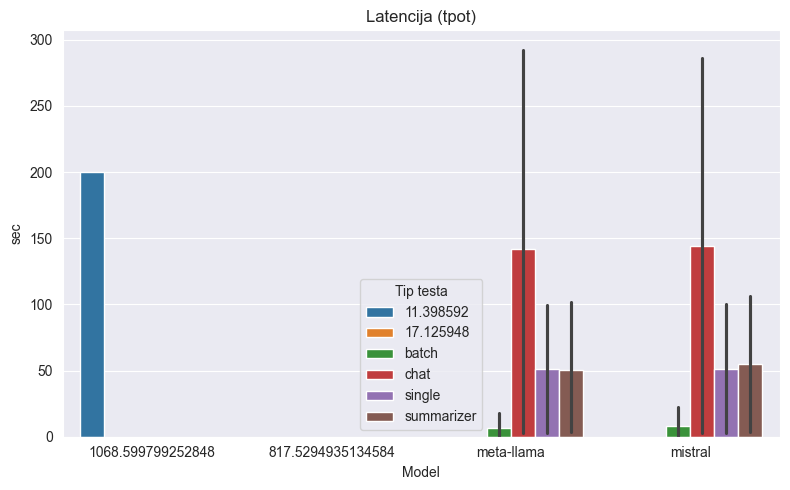

In [89]:
# TIP TESTA
# Vizualizacija: TTFT po modelima za oba tipa testiranja
plt.figure(figsize=(8,5))
sns.barplot(data=stress_summary, x='model', y='ttft', hue='test_name')
plt.title('Prosječni TTFT po modelima i tipu testa')
plt.ylabel('TTFT [ms]')
plt.xlabel('Model')
plt.legend(title='Tip testa')
plt.tight_layout()
plt.show()

# Vizualizacija: tokens_per_sec po modelima i tipu testa
plt.figure(figsize=(8,5))
sns.barplot(data=summary, x='model', y='tokens_per_sec', hue='test_name')
plt.title('Prosječan broj tokena u sekundi (tokens_per_sec)')
plt.ylabel('Tokens / sec')
plt.xlabel('Model')
plt.legend(title='Tip testa')
plt.tight_layout()
plt.show()

# Vizualizacija: tpot po modelima i tipu testa
plt.figure(figsize=(8,5))
sns.barplot(data=summary, x='model', y='tpot', hue='test_name')
plt.title('Time per output token (tpot)')
plt.ylabel('Tokens / sec')
plt.xlabel('Model')
plt.legend(title='Tip testa')
plt.tight_layout()
plt.show()

# Vizualizacija: tpot po modelima i tipu testa
plt.figure(figsize=(8,5))
sns.barplot(data=summary, x='model', y='latency', hue='test_name')
plt.title('Latencija (tpot)')
plt.ylabel('sec')
plt.xlabel('Model')
plt.legend(title='Tip testa')
plt.tight_layout()
plt.show()

# Vizualizacija: tokens_per_sec po modelima i tipu testa
plt.figure(figsize=(8,5))
sns.barplot(data=summary, x='model', y='tokens_per_sec', hue='test_name')
plt.title('Prosječan broj tokena u sekundi (tokens_per_sec)')
plt.ylabel('Tokens / sec')
plt.xlabel('Model')
plt.legend(title='Tip testa')
plt.tight_layout()
plt.show()

# Vizualizacija: tpot po modelima i tipu testa
plt.figure(figsize=(8,5))
sns.barplot(data=summary, x='model', y='tpot', hue='test_name')
plt.title('Time per output token (tpot)')
plt.ylabel('Tokens / sec')
plt.xlabel('Model')
plt.legend(title='Tip testa')
plt.tight_layout()
plt.show()

# Vizualizacija: tpot po modelima i tipu testa
plt.figure(figsize=(8,5))
sns.barplot(data=summary, x='model', y='latency', hue='test_name')
plt.title('Latencija (tpot)')
plt.ylabel('sec')
plt.xlabel('Model')
plt.legend(title='Tip testa')
plt.tight_layout()
plt.show()

# TRITON ANALIZA

In [37]:
df_triton.head(1)
df = df_triton.copy()
df = df[~df['model'].str.contains('rt-')]
df['test'] = (df['test'].astype(str) + '_b' + df['batch_size'].astype(str) + '_' + df['floating_point'].astype(str) +
              '_kv' + df['kv_cache'].astype(str))

df

,test,model,batch_size,floating_point,concurrency_range,kv_cache,Concurrency,Inferences/Second,Client Send,Network+Server Send/Recv,...,Server Compute Output,Client Recv,p50 latency,p90 latency,p95 latency,p99 latency,request/response,response wait,test_type,concurrency
0,omega_b1_fp16_kv0,gemma3,1,fp16,1:64:16,0,49,0.642323,209,2978,...,43,0,73581478,75187610,75229470,75273560,209,71786625,neoptimizirano,NaN
1,omega_b1_fp16_kv0,gemma3,1,fp16,1:64:16,0,1,0.642326,50,775,...,38,0,1521312,1523512,1523770,1527918,50,1521517,neoptimizirano,NaN
2,omega_b1_fp16_kv0,gemma3,1,fp16,1:64:16,0,17,0.659680,63,871,...,41,0,25870751,26333939,26346074,26362752,63,25661254,neoptimizirano,NaN
3,omega_b1_fp16_kv0,gemma3,1,fp16,1:64:16,0,33,0.659680,70,885,...,39,0,47532890,49436611,50688167,50691014,70,47278828,neoptimizirano,NaN
4,omega_b1_fp16_kv0,mistral,1,fp16,1:64:16,0,33,0.374981,71,850,...,38,0,86245511,86270158,86275411,86277690,71,84864391,neoptimizirano,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351,eta_b8_f32_kv4096,meta-llama,8,f32,NaN,4096,97,9.975200,63,819,...,41,0,77767894,78726780,78977638,79291565,63,76401304,optimizirano,1:128:16
352,eta_b8_f32_kv4096,meta-llama,8,f32,NaN,4096,17,9.975210,57,852,...,40,0,12934665,17306819,17947289,18699054,57,13441151,optimizirano,1:128:16
353,eta_b8_f32_kv4096,meta-llama,8,f32,NaN,4096,49,10.049300,68,825,...,40,0,38963063,40112804,40538449,41501947,68,38439086,optimizirano,1:128:16
354,eta_b8_f32_kv4096,meta-llama,8,f32,NaN,4096,65,10.061600,60,838,...,41,0,51581422,52862652,53235062,53730334,60,50795105,optimizirano,1:128:16


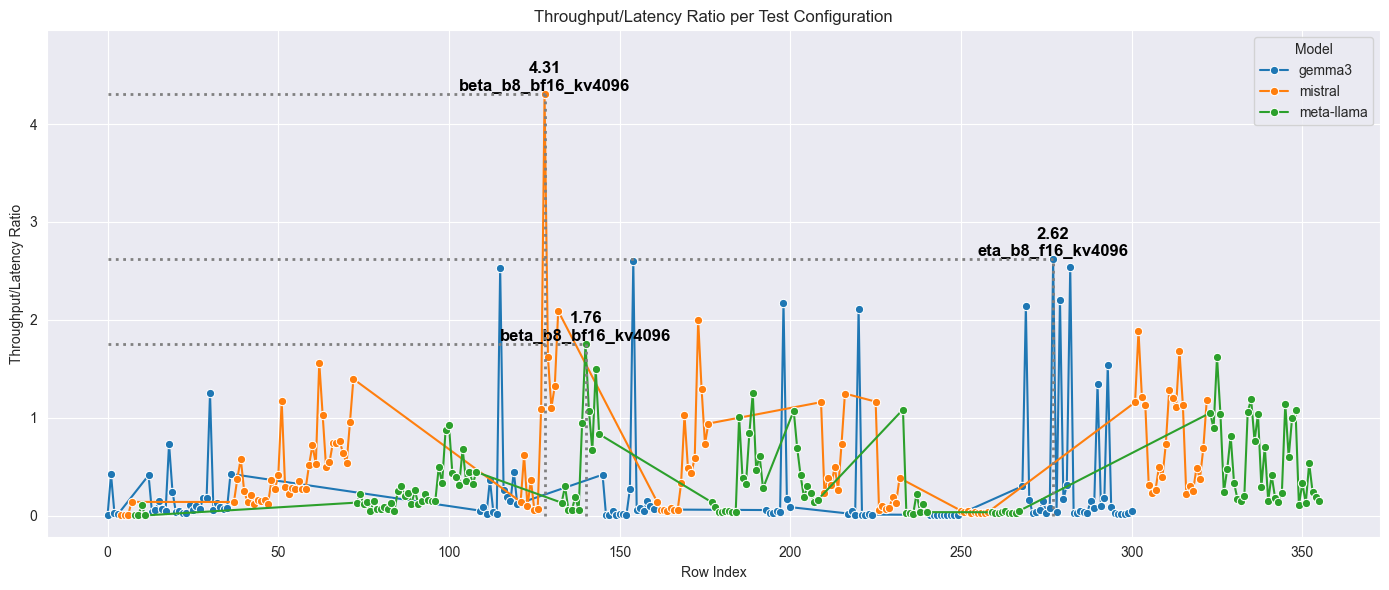

In [57]:
#Zadrži samo relevantne kolone\n",
df_filtered = df[
 ['test', 'model', 'batch_size',
  'Concurrency', 'Inferences/Second',
'p50 latency', 'p90 latency', 'p95 latency', 'p99 latency', 'response wait']].copy()

# convert latency columns to seconds from microseconds
df_filtered['p50 latency'] = round(df_filtered['p50 latency'] / 1000000, 3)
df_filtered['p90 latency'] = round(df_filtered['p90 latency'] / 1000000, 3)
df_filtered['p95 latency'] = round(df_filtered['p95 latency'] / 1000000, 3)
df_filtered['p99 latency'] = round(df_filtered['p99 latency'] / 1000000, 3)

# Add a combined metric
df_filtered['throughput_latency_ratio'] = df_filtered['Inferences/Second'] / df_filtered['p99 latency']
# For each test and model, get the row with the highest ratio
df_plot = df_filtered.reset_index()
max_points = df_plot.loc[df_plot.groupby('model')['throughput_latency_ratio'].idxmax()]

plt.figure(figsize=(14, 6))
max_y = df_plot['throughput_latency_ratio'].max()
sns.lineplot(
    data=df_plot,
    x='index',
    y='throughput_latency_ratio',
    hue='model',
    marker='o'
)

for _, row in max_points.iterrows():
    plt.text(
        row['index'],
        row['throughput_latency_ratio'],
        f"{row['throughput_latency_ratio']:.2f}\n{row['test']}",
        color='black',
        fontsize=12,
        fontweight='bold',
        ha='center',
        va='bottom'
    )
    # Vertical line
    plt.vlines(
        x=row['index'],
        ymin=0,
        ymax=row['throughput_latency_ratio'],
        color='gray',
        linestyle='dotted',
        linewidth=2,
        zorder=5
    )
    # Horizontal line
    plt.hlines(
        y=row['throughput_latency_ratio'],
        xmin=0,
        xmax=row['index'],
        color='gray',
        linestyle='dotted',
        linewidth=2,
        zorder=5
    )

plt.ylim(top=max_y * 1.15)
plt.title('Throughput/Latency Ratio per Test Configuration')
plt.xlabel('Row Index')
plt.ylabel('Throughput/Latency Ratio')
plt.legend(title='Model')
plt.tight_layout()
plt.show()

In [47]:
best_rows = df_filtered.loc[df_filtered.groupby(['model'])['throughput_latency_ratio'].idxmax()]

# order by highest throughput_latency_ratio
best_rows = best_rows.sort_values(by='throughput_latency_ratio', ascending=False)
# Display the best rows
best_rows.reset_index(drop=True, inplace=True)
best_rows.head(10)

,test,model,batch_size,Concurrency,Inferences/Second,p50 latency,p90 latency,p95 latency,p99 latency,response wait,throughput_latency_ratio
0,beta_b8_bf16_kv4096,mistral,8,5,13.64180,2.917,3.045,3.082,3.165,2926345,4.310205
1,eta_b8_f16_kv4096,gemma3,8,1,4.58020,1.741,1.746,1.747,1.749,1749885,2.618754
2,beta_b8_bf16_kv4096,meta-llama,8,5,9.02461,4.403,4.839,4.929,5.139,4424416,1.756102


In [226]:
# from the best rows get the best for each model
best_per_model = best_rows.loc[best_rows.groupby('model')['throughput_latency_ratio'].idxmax()]
best_per_model = best_per_model.sort_values(by='throughput_latency_ratio', ascending=False)
# Reset index for better readability
best_per_model.reset_index(drop=True, inplace=True)
# Display the best rows
best_per_model.head(20)

# remove batch size. p50 latency, p90 latency, response wait
best_per_model = best_per_model.drop(columns=['p50 latency', 'p90 latency', 'p95 latency', 'response wait'])
# Display the best rows
best_per_model.reset_index(drop=True, inplace=True)
best_per_model

,test,model,batch_size,Concurrency,Inferences/Second,p99 latency,throughput_latency_ratio
0,beta_b8_bf16_kv4096,mistral,8,5,13.64180,3.165,4.310205
1,eta_b8_f16_kv4096,gemma3,8,1,4.58020,1.749,2.618754
2,beta_b8_bf16_kv4096,meta-llama,8,5,9.02461,5.139,1.756102


In [227]:
# Create a dictionary to hold the dataframes for each model
model_dfs = {}
unique_models = best_rows['model'].unique()

# Split the dataframe by model
for model in unique_models:
    # Sort by the ratio to have the best results on top for each model
    model_df = best_rows[best_rows['model'] == model].sort_values(by='throughput_latency_ratio', ascending=False)
    model_dfs[model] = model_df

# Display the table for each model
for model_name, df_model in model_dfs.items():
    print(f"### Best configurations for {model_name}")
    display(df_model.head(1))
    print("\n")

### Best configurations for mistral


,test,model,batch_size,Concurrency,Inferences/Second,p50 latency,p90 latency,p95 latency,p99 latency,response wait,throughput_latency_ratio
0,beta_b8_bf16_kv4096,mistral,8,5,13.6418,2.917,3.045,3.082,3.165,2926345,4.310205




### Best configurations for gemma3


,test,model,batch_size,Concurrency,Inferences/Second,p50 latency,p90 latency,p95 latency,p99 latency,response wait,throughput_latency_ratio
1,eta_b8_f16_kv4096,gemma3,8,1,4.5802,1.741,1.746,1.747,1.749,1749885,2.618754




### Best configurations for meta-llama


,test,model,batch_size,Concurrency,Inferences/Second,p50 latency,p90 latency,p95 latency,p99 latency,response wait,throughput_latency_ratio
2,beta_b8_bf16_kv4096,meta-llama,8,5,9.02461,4.403,4.839,4.929,5.139,4424416,1.756102


In [228]:
worst_rows = df_filtered.loc[df_filtered.groupby(['model'])['Inferences/Second'].idxmin()]

# order by highest throughput_latency_ratio
worst_rows = worst_rows.sort_values(by='Inferences/Second', ascending=False)
# Display the best rows
worst_rows.reset_index(drop=True, inplace=True)
worst_rows.head(10)

,test,model,batch_size,Concurrency,Inferences/Second,p50 latency,p90 latency,p95 latency,p99 latency,response wait,throughput_latency_ratio
0,omega_b1_fp16_kv0,gemma3,1,49,0.642323,73.581,75.188,75.229,75.274,71786625,0.008533
1,omega_b1_fp16_kv0,mistral,1,33,0.374981,86.246,86.270,86.275,86.278,84864391,0.004346
2,omega_b1_fp16_kv0,meta-llama,1,33,0.333312,98.365,98.970,99.005,99.061,98379817,0.003365


In [229]:
# now combimne the best and worst rows

combined_best_worst = pd.concat([best_per_model, worst_rows], ignore_index=True)
# Display the combined best and worst rows

combined_best_worst.reset_index(drop=True, inplace=True)
combined_best_worst.head(20)


,test,model,batch_size,Concurrency,Inferences/Second,p99 latency,throughput_latency_ratio,p50 latency,p90 latency,p95 latency,response wait
0,beta_b8_bf16_kv4096,mistral,8,5,13.641800,3.165,4.310205,NaN,NaN,NaN,NaN
1,eta_b8_f16_kv4096,gemma3,8,1,4.580200,1.749,2.618754,NaN,NaN,NaN,NaN
2,beta_b8_bf16_kv4096,meta-llama,8,5,9.024610,5.139,1.756102,NaN,NaN,NaN,NaN
3,omega_b1_fp16_kv0,gemma3,1,49,0.642323,75.274,0.008533,73.581,75.188,75.229,71786625.0
4,omega_b1_fp16_kv0,mistral,1,33,0.374981,86.278,0.004346,86.246,86.270,86.275,84864391.0
5,omega_b1_fp16_kv0,meta-llama,1,33,0.333312,99.061,0.003365,98.365,98.970,99.005,98379817.0


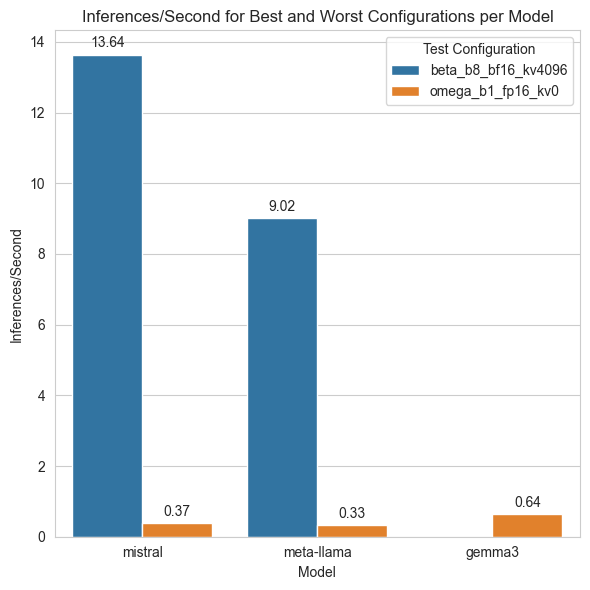

In [237]:
# create a bar plot for the best and worst rows per each model
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
model_order = ['mistral', 'meta-llama', 'gemma3']
# Create a bar plot for Inferences/Second
plt.figure(figsize=(6, 6))
ax = sns.barplot(data=combined_best_worst, x='model', y='Inferences/Second', hue='test', order=model_order)

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=10, padding=3)

plt.title('Inferences/Second for Best and Worst Configurations per Model')
plt.xlabel('Model')
plt.ylabel('Inferences/Second')

plt.legend(title='Test Configuration')
plt.tight_layout()
plt.show()


In [231]:
# Assume 'summary' contains ttft per model/test_name/test_type
# Get the worst ttft per model
worst_ttft_per_model = summary.loc[summary.groupby('model')['latency'].idxmax()]

# Merge with worst_rows on 'model'
merged = pd.merge(
    worst_rows[['model', 'Inferences/Second', 'test', 'p99 latency']],
    worst_ttft_per_model[['model', 'ttft', 'tpot', 'tokens_per_sec', 'latency', 'test_name', 'test_type']],
    on='model',
    suffixes=('_inferences', '_ttft')
)

display(merged)

# save to a dataframe
worst_per_model = merged.copy()


,model,Inferences/Second,test,p99 latency,ttft,tpot,tokens_per_sec,latency,test_name,test_type
0,gemma3,0.642323,omega_b1_fp16_kv0,75.274,36.920639,0.003018,331.385987,36.929745,summarizer,smoke_optimizirano
1,mistral,0.374981,omega_b1_fp16_kv0,86.278,372.947117,0.562653,3.262973,372.972992,chat,stress_neoptimizirano
2,meta-llama,0.333312,omega_b1_fp16_kv0,99.061,389.026299,0.459715,3.181440,389.053141,chat,stress_neoptimizirano


In [287]:
# Assume 'summary' contains ttft per model/test_name/test_type
# Get the worst ttft per model

stress_opt_summary = summary[summary['test_type'] == 'stress_optimizirano']


best_latency_per_model = stress_opt_summary.loc[stress_opt_summary.groupby('model')['latency'].idxmin()]

# Merge with worst_rows on 'model'
merged = pd.merge(
    best_rows[['model', 'Inferences/Second', 'test', 'p99 latency']],
    best_latency_per_model[['model', 'ttft', 'tpot', 'tokens_per_sec', 'latency', 'test_name', 'test_type']],
    on='model',
    suffixes=('_inferences', '_latency')
)

display(merged)

best_per_model = merged.copy()

,model,Inferences/Second,test,p99 latency,ttft,tpot,tokens_per_sec,latency,test_name,test_type
0,mistral,13.64180,beta_b8_bf16_kv4096,3.165,30.208429,0.249207,4.698460,30.219084,batch,stress_optimizirano
1,meta-llama,9.02461,beta_b8_bf16_kv4096,5.139,24.084497,0.172753,6.186261,24.094519,batch,stress_optimizirano


In [284]:
# merge the best and worst per model df
worst_per_model['type'] = 'worst'
best_per_model['type'] = 'best'
combined_best_worst = pd.concat([best_per_model, worst_per_model], ignore_index=True)
# Display the combined best and worst rows
combined_best_worst.reset_index(drop=True, inplace=True)
combined_best_worst.head(20)

,model,Inferences/Second,test,p99 latency,ttft,tpot,tokens_per_sec,latency,test_name,test_type,type
0,mistral,13.641800,beta_b8_bf16_kv4096,3.165,30.208429,0.249207,4.698460,30.219084,batch,stress_optimizirano,best
1,meta-llama,9.024610,beta_b8_bf16_kv4096,5.139,24.084497,0.172753,6.186261,24.094519,batch,stress_optimizirano,best
2,gemma3,0.642323,omega_b1_fp16_kv0,75.274,36.920639,0.003018,331.385987,36.929745,summarizer,smoke_optimizirano,worst
3,mistral,0.374981,omega_b1_fp16_kv0,86.278,372.947117,0.562653,3.262973,372.972992,chat,stress_neoptimizirano,worst
4,meta-llama,0.333312,omega_b1_fp16_kv0,99.061,389.026299,0.459715,3.181440,389.053141,chat,stress_neoptimizirano,worst


In [285]:
print(combined_best_worst.columns)

Index(['model', 'Inferences/Second', 'test', 'p99 latency', 'ttft', 'tpot',
       'tokens_per_sec', 'latency', 'test_name', 'test_type', 'type'],
      dtype='object')


Improvements for ttft:
type       model       best       worst  ttft_improvement
0         gemma3        NaN   36.920639               NaN
1     meta-llama  24.084497  389.026299             16.15
2        mistral  30.208429  372.947117             12.35




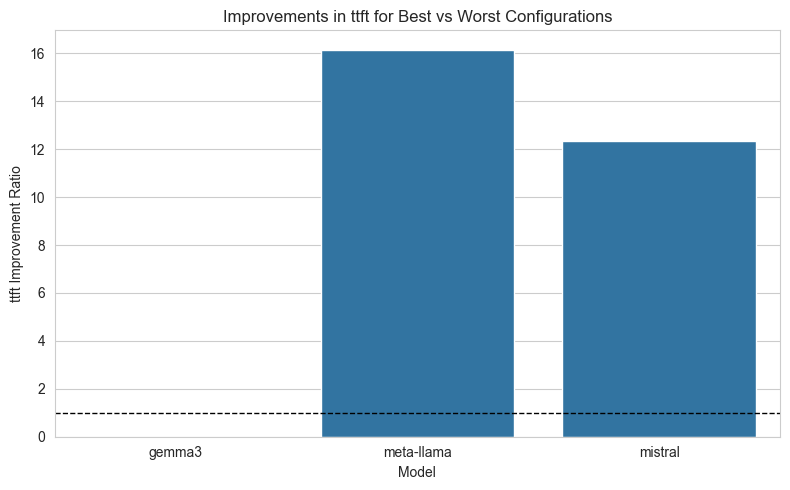

Improvements for tpot:
type       model      best     worst  tpot_improvement
0         gemma3       NaN  0.003018               NaN
1     meta-llama  0.172753  0.459715              2.66
2        mistral  0.249207  0.562653              2.26




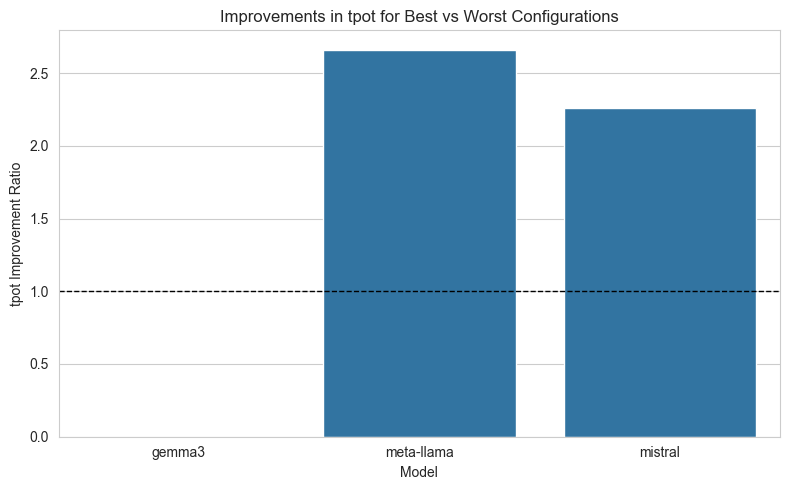

Improvements for tokens_per_sec:
type       model      best       worst  tokens_per_sec_improvement
0         gemma3       NaN  331.385987                         NaN
1     meta-llama  6.186261    3.181440                        0.51
2        mistral  4.698460    3.262973                        0.69




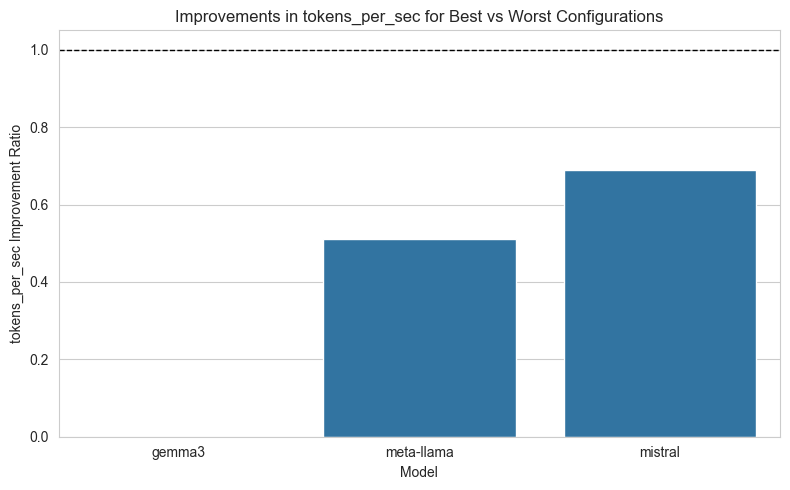

Improvements for latency:
type       model       best       worst  latency_improvement
0         gemma3        NaN   36.929745                  NaN
1     meta-llama  24.094519  389.053141                16.15
2        mistral  30.219084  372.972992                12.34




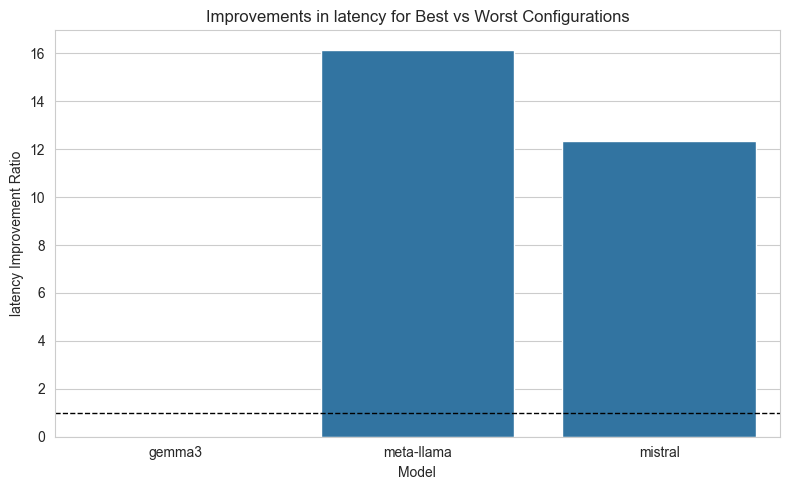

Improvements for p99 latency:
type       model   best   worst  p99 latency_improvement
0         gemma3    NaN  75.274                      NaN
1     meta-llama  5.139  99.061                    19.28
2        mistral  3.165  86.278                    27.26




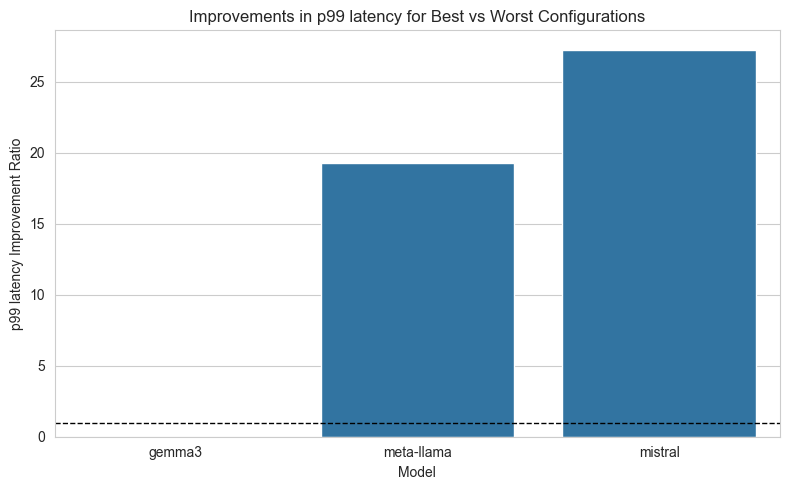

In [319]:
def calculate_improvements(df, metric):
    pivot = df.pivot(index='model', columns='type', values=metric).reset_index()
    if metric == ['tpot', 'tokens_per_sec']:
        pivot[f'{metric}_improvement'] = (pivot['best'] / pivot['worst']).round(2)
    else:
        pivot[f'{metric}_improvement'] = (pivot['worst'] / pivot['best']).round(2)
    return pivot[['model', 'best', 'worst', f'{metric}_improvement']]

metrics = ['ttft', 'tpot', 'tokens_per_sec', 'latency', 'p99 latency']




for metric in metrics:
    improvements = calculate_improvements(combined_best_worst, metric)
    print(f"Improvements for {metric}:")
    print(improvements)
    print("\n")

# create a plot for each metric
    plt.figure(figsize=(8, 5))
    sns.barplot(data=improvements, x='model', y=f'{metric}_improvement')
    plt.title(f'Improvements in {metric} for Best vs Worst Configurations')
    plt.ylabel(f'{metric} Improvement Ratio')
    plt.xlabel('Model')
    plt.axhline(1, color='black', linewidth=1, linestyle='--')  # Line at 1 for reference
    plt.tight_layout()
    plt.show()



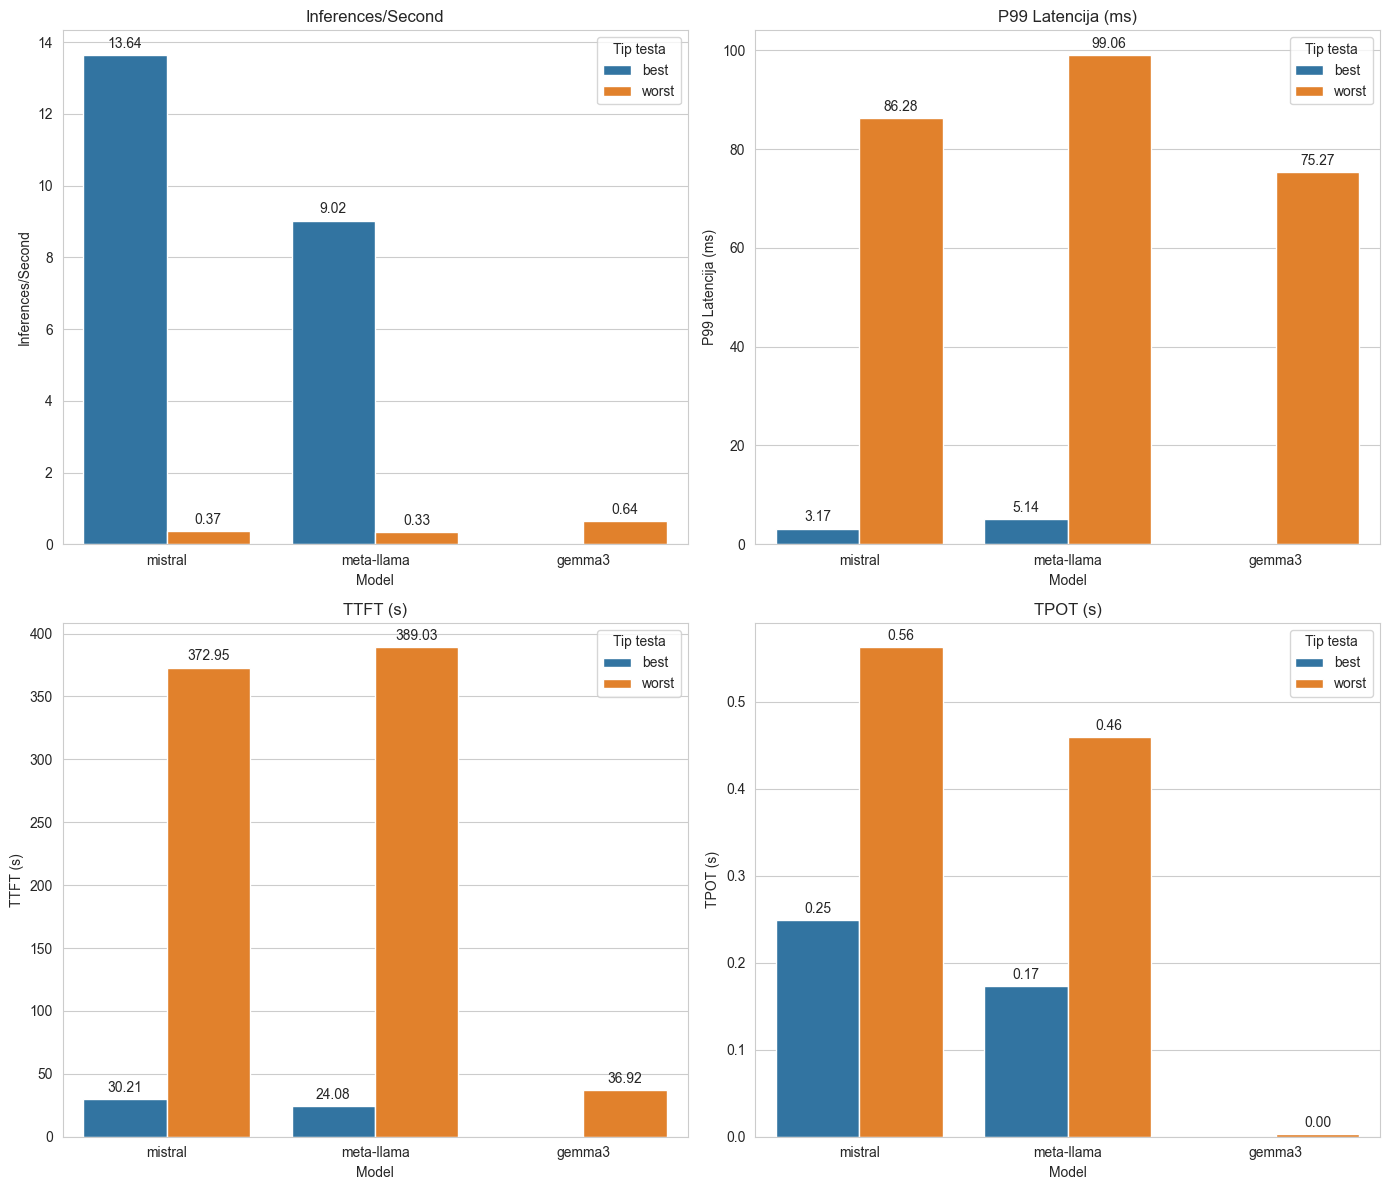

In [235]:
sns.set_style('whitegrid')
fig, axs = plt.subplots(2, 2, figsize=(14, 12))

metrics = ['Inferences/Second', 'p99 latency', 'ttft', 'tpot']
titles = ['Inferences/Second', 'P99 Latencija (ms)', 'TTFT (s)', 'TPOT (s)']

for ax, metric, title in zip(axs.flatten(), metrics, titles):
    sns.barplot(data=combined_best_worst, x='model', y=metric, hue='type', ax=ax)
    ax.set_title(title)
    ax.set_ylabel(title)
    ax.set_xlabel('Model')
    ax.legend(title='Tip testa')
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=10, padding=3)

plt.tight_layout()
plt.show()
